# Linear Regression with PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

# Datasets

## Generating dataset

We obtain the datasets from a linear model, given $x$, we write
$$y := Ax + b$$ where $x \in \mathbb{R}^i$ and $y \in \mathbb{R}^o$ where $i$ and $o$ are the input and output dimension respectively.

In [2]:
input_dim = 1
output_dim = 1
A = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.random(output_dim) - 1

true_model = lambda x: A @ x + b

To get the training set, we can use noisy distributions. We consider the points as follows
$$ x_i \sim {U}([-1,1]) $$
$$ y_i = Ax_i + B + \nu_i$$ where $\nu_i \sim \mathcal{N}(0,1)$

In [3]:
n_train = 1000
noise_lvl = 0.04
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

y_train += noise_lvl * np.random.standard_normal(size=y_train.shape)

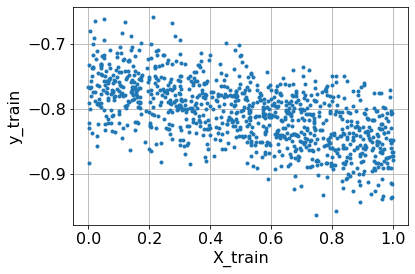

In [4]:
fig = plt.figure()
ax = fig.gca()
ax.plot(X_train, y_train, '.')
ax.grid(True)
ax.set_xlabel('X_train')
ax.set_ylabel('y_train')
plt.show()

## Dataset class

In [5]:
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
        
    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], 
                  self.output_data[idx, :])  
        return sample 

In [6]:
training_set = VectorialDataset(input_data = X_train, output_data = y_train)
print(len(training_set))

1000


In [7]:
training_set[0]

(tensor([0.5607]), tensor([-0.8110]))

## DataLoader class

In [8]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

# Linear model

In [9]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out
    
    def reset(self):
        self.linear.reset_parameters()

In [10]:
model = LinearModel(input_dim, output_dim)
print(model)
print(list(model.parameters()))
print(model.linear.weight)
print(model.linear.bias)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
[Parameter containing:
tensor([[-0.1033]], requires_grad=True), Parameter containing:
tensor([-0.3156], requires_grad=True)]
Parameter containing:
tensor([[-0.1033]], requires_grad=True)
Parameter containing:
tensor([-0.3156], requires_grad=True)


## Moving forward

In [11]:
x = torch.randn(5, input_dim)
print(model.forward(x)) # Just prints wx+b

tensor([[-0.4054],
        [-0.4048],
        [-0.1712],
        [-0.3647],
        [-0.3233]], grad_fn=<AddmmBackward0>)


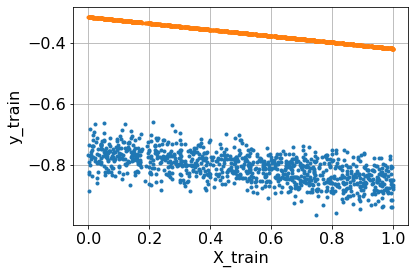

In [12]:
fig = plt.figure()
ax = fig.gca()
ax.plot(training_set.input_data, training_set.output_data, '.')
ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
ax.grid(True)
ax.set_xlabel('X_train')
ax.set_ylabel('y_train')
plt.show()

## Loss

In [13]:
loss_function = nn.MSELoss(reduction='mean')

In [14]:
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_function(x, z)

tensor(2.)

The MSELoss is $ L(x,z) =||x-z||_2^2$. For the training set, it is given as
$$ L(X_{train}, Y_{train}) = \dfrac{1}{n_{train}}\sum_{i=1}^{n_{train}} L(model(x_i), y_i) $$

## Visualize the optimal solution

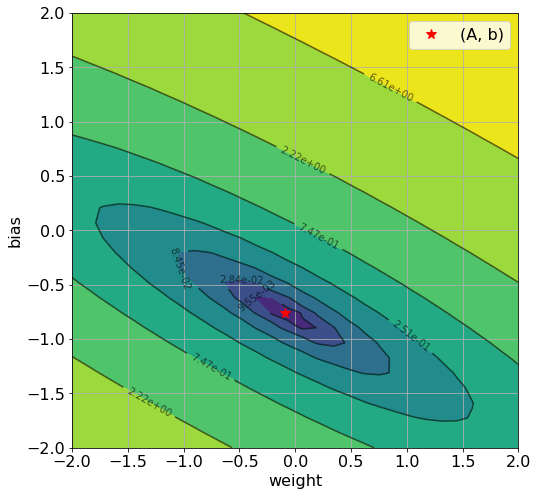

In [15]:
state_dict = model.state_dict()
ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))
loss_values = 0 * ww
for i in range(ww.shape[0]):
    for j in range(ww.shape[1]):
        state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
        state_dict['linear.bias'] = torch.tensor([bb[i, j]])
        model.load_state_dict(state_dict)
        loss_values[i, j] = loss_function(model.forward(training_set.input_data), training_set.output_data)

        
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
lvls = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
ax.contourf(ww, bb, loss_values, levels=lvls, norm=colors.LogNorm(vmin=np.min(loss_values), vmax=np.max(loss_values)))
c = ax.contour(ww, bb, loss_values, levels=lvls, norm=colors.LogNorm(vmin=np.min(loss_values), vmax=np.max(loss_values)), 
                colors='k', alpha=0.6)

ax.clabel(c, fmt='%2.2e', inline=1, fontsize=10, colors='k')
ax.plot(A[0], b, 'r*', markersize=10)
ax.set_ylabel('bias')
ax.set_xlabel('weight')
ax.legend(['(A, b)'])
ax.grid(True)

## Optimization

We can use iterative gradient based optimization with a learning rate $\eta$. Now note that we need to compute $L(x,y) = (model(x) - y)^2$. Thus we have $L(x, y) = (ax+b-y)^2$. For this, we can get the two gradients as:
$$ \nabla_a L(x,y) = 2x(ax+b-y)$$
$$ \nabla_b L(x,y) = 2(ax+b-y)$$

In [16]:
x = torch.randn(1, input_dim)
y = torch.randn(1, output_dim)
model.zero_grad()
loss = loss_function(model.forward(x), y)
loss.backward()

In [17]:
print(model.linear.weight.grad)
print(2 * x *(model.linear.weight * x + model.linear.bias - y))
print()
print(model.linear.bias.grad)
print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[6.0182]])
tensor([[6.0182]], grad_fn=<MulBackward0>)

tensor([-4.1012])
tensor([[-4.1012]], grad_fn=<MulBackward0>)


In [18]:
# Optimizer

num_iter = 200
lr = 0.5

train_hist = {}
train_hist['weight'] = []
train_hist['bias'] = []
model.reset()

state_dict = model.state_dict()

for _ in range(num_iter):
    model.zero_grad()
    loss = loss_function(model.forward(training_set.input_data), training_set.output_data)
    loss.backward()
    w = model.linear.weight.item()
    b = model.linear.bias.item()
    
    dw = model.linear.weight.grad.item()
    db = model.linear.bias.grad.item()
    
    state_dict['linear.weight'] += torch.tensor([-lr * dw])
    state_dict['linear.bias'] += torch.tensor([-lr * db])
    model.load_state_dict(state_dict)
    
    train_hist['weight'].append(w)
    train_hist['bias'].append(b)
    
for label in train_hist:
    train_hist[label] = np.array(train_hist[label])

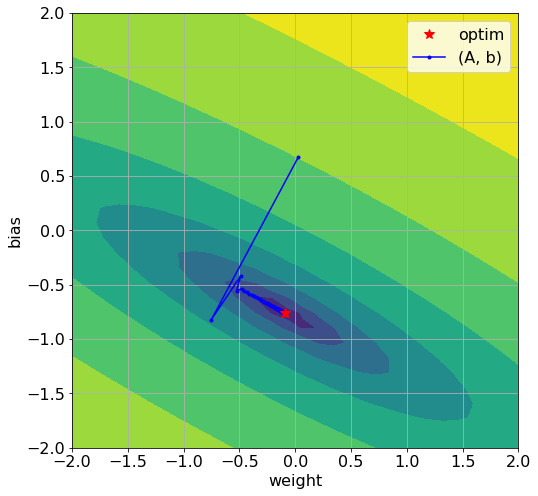

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
lvls = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
ax.contourf(ww, bb, loss_values, levels=lvls, norm=colors.LogNorm(vmin=np.min(loss_values), vmax=np.max(loss_values)))

ax.clabel(c, fmt='%2.2e', inline=1, fontsize=10, colors='k')
ax.plot(A[0], b, 'r*', markersize=10)
ax.set_ylabel('bias')
ax.set_xlabel('weight')
ax.legend(['(A, b)'])
ax.grid(True)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
ax.plot(A[0], b, 'r*', markersize=10)
ax.legend(['optim', '(A, b)'])
plt.show()

## Inbuilt optim

In [21]:
lr = 0.1
weight_decay = 5e-4
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [22]:
n_epochs = 100

In [25]:
train_hist = {}
train_hist['loss'] = []
train_hist['weight'] = []
train_hist['bias'] = []
model.reset()
model.train()
for e in range(n_epochs):
    for i, batch in enumerate(train_loader):
        opt.zero_grad()
        loss = loss_function(model.forward(batch[0]), batch[1])
        loss.backward()
        opt.step()
        
        train_hist['loss'].append(loss.item())
        train_hist['weight'].append(model.linear.weight.item())
        train_hist['bias'].append(model.linear.bias.item())
        
        print('[Epcoh %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (e+1, n_epochs, i+1, len(train_loader), loss.item()))

[Epcoh    1/ 100] [Batch    1/   9] Loss:  1.91e-01
[Epcoh    1/ 100] [Batch    2/   9] Loss:  1.08e-01
[Epcoh    1/ 100] [Batch    3/   9] Loss:  7.12e-02
[Epcoh    1/ 100] [Batch    4/   9] Loss:  4.32e-02
[Epcoh    1/ 100] [Batch    5/   9] Loss:  5.46e-02
[Epcoh    1/ 100] [Batch    6/   9] Loss:  8.08e-02
[Epcoh    1/ 100] [Batch    7/   9] Loss:  1.18e-01
[Epcoh    1/ 100] [Batch    8/   9] Loss:  1.09e-01
[Epcoh    1/ 100] [Batch    9/   9] Loss:  1.26e-01
[Epcoh    2/ 100] [Batch    1/   9] Loss:  8.78e-02
[Epcoh    2/ 100] [Batch    2/   9] Loss:  7.33e-02
[Epcoh    2/ 100] [Batch    3/   9] Loss:  5.77e-02
[Epcoh    2/ 100] [Batch    4/   9] Loss:  3.62e-02
[Epcoh    2/ 100] [Batch    5/   9] Loss:  3.09e-02
[Epcoh    2/ 100] [Batch    6/   9] Loss:  2.62e-02
[Epcoh    2/ 100] [Batch    7/   9] Loss:  2.18e-02
[Epcoh    2/ 100] [Batch    8/   9] Loss:  2.85e-02
[Epcoh    2/ 100] [Batch    9/   9] Loss:  3.25e-02
[Epcoh    3/ 100] [Batch    1/   9] Loss:  3.95e-02
[Epcoh    3/

[Epcoh   20/ 100] [Batch    7/   9] Loss:  1.61e-03
[Epcoh   20/ 100] [Batch    8/   9] Loss:  1.50e-03
[Epcoh   20/ 100] [Batch    9/   9] Loss:  1.72e-03
[Epcoh   21/ 100] [Batch    1/   9] Loss:  1.61e-03
[Epcoh   21/ 100] [Batch    2/   9] Loss:  1.71e-03
[Epcoh   21/ 100] [Batch    3/   9] Loss:  1.72e-03
[Epcoh   21/ 100] [Batch    4/   9] Loss:  1.89e-03
[Epcoh   21/ 100] [Batch    5/   9] Loss:  1.54e-03
[Epcoh   21/ 100] [Batch    6/   9] Loss:  1.70e-03
[Epcoh   21/ 100] [Batch    7/   9] Loss:  1.64e-03
[Epcoh   21/ 100] [Batch    8/   9] Loss:  1.65e-03
[Epcoh   21/ 100] [Batch    9/   9] Loss:  1.49e-03
[Epcoh   22/ 100] [Batch    1/   9] Loss:  2.04e-03
[Epcoh   22/ 100] [Batch    2/   9] Loss:  1.53e-03
[Epcoh   22/ 100] [Batch    3/   9] Loss:  1.77e-03
[Epcoh   22/ 100] [Batch    4/   9] Loss:  1.49e-03
[Epcoh   22/ 100] [Batch    5/   9] Loss:  1.44e-03
[Epcoh   22/ 100] [Batch    6/   9] Loss:  1.59e-03
[Epcoh   22/ 100] [Batch    7/   9] Loss:  1.62e-03
[Epcoh   22/

[Epcoh   41/ 100] [Batch    3/   9] Loss:  1.49e-03
[Epcoh   41/ 100] [Batch    4/   9] Loss:  1.58e-03
[Epcoh   41/ 100] [Batch    5/   9] Loss:  1.50e-03
[Epcoh   41/ 100] [Batch    6/   9] Loss:  2.01e-03
[Epcoh   41/ 100] [Batch    7/   9] Loss:  1.84e-03
[Epcoh   41/ 100] [Batch    8/   9] Loss:  1.45e-03
[Epcoh   41/ 100] [Batch    9/   9] Loss:  1.77e-03
[Epcoh   42/ 100] [Batch    1/   9] Loss:  1.43e-03
[Epcoh   42/ 100] [Batch    2/   9] Loss:  1.62e-03
[Epcoh   42/ 100] [Batch    3/   9] Loss:  1.47e-03
[Epcoh   42/ 100] [Batch    4/   9] Loss:  1.69e-03
[Epcoh   42/ 100] [Batch    5/   9] Loss:  1.55e-03
[Epcoh   42/ 100] [Batch    6/   9] Loss:  1.71e-03
[Epcoh   42/ 100] [Batch    7/   9] Loss:  1.95e-03
[Epcoh   42/ 100] [Batch    8/   9] Loss:  1.64e-03
[Epcoh   42/ 100] [Batch    9/   9] Loss:  1.78e-03
[Epcoh   43/ 100] [Batch    1/   9] Loss:  1.45e-03
[Epcoh   43/ 100] [Batch    2/   9] Loss:  1.62e-03
[Epcoh   43/ 100] [Batch    3/   9] Loss:  1.80e-03
[Epcoh   43/

[Epcoh   61/ 100] [Batch    9/   9] Loss:  1.58e-03
[Epcoh   62/ 100] [Batch    1/   9] Loss:  1.68e-03
[Epcoh   62/ 100] [Batch    2/   9] Loss:  1.75e-03
[Epcoh   62/ 100] [Batch    3/   9] Loss:  1.58e-03
[Epcoh   62/ 100] [Batch    4/   9] Loss:  1.87e-03
[Epcoh   62/ 100] [Batch    5/   9] Loss:  1.65e-03
[Epcoh   62/ 100] [Batch    6/   9] Loss:  1.56e-03
[Epcoh   62/ 100] [Batch    7/   9] Loss:  1.48e-03
[Epcoh   62/ 100] [Batch    8/   9] Loss:  1.60e-03
[Epcoh   62/ 100] [Batch    9/   9] Loss:  1.39e-03
[Epcoh   63/ 100] [Batch    1/   9] Loss:  1.42e-03
[Epcoh   63/ 100] [Batch    2/   9] Loss:  1.39e-03
[Epcoh   63/ 100] [Batch    3/   9] Loss:  1.59e-03
[Epcoh   63/ 100] [Batch    4/   9] Loss:  1.41e-03
[Epcoh   63/ 100] [Batch    5/   9] Loss:  1.68e-03
[Epcoh   63/ 100] [Batch    6/   9] Loss:  1.97e-03
[Epcoh   63/ 100] [Batch    7/   9] Loss:  1.92e-03
[Epcoh   63/ 100] [Batch    8/   9] Loss:  1.50e-03
[Epcoh   63/ 100] [Batch    9/   9] Loss:  2.26e-03
[Epcoh   64/

[Epcoh   81/ 100] [Batch    3/   9] Loss:  1.49e-03
[Epcoh   81/ 100] [Batch    4/   9] Loss:  2.04e-03
[Epcoh   81/ 100] [Batch    5/   9] Loss:  1.68e-03
[Epcoh   81/ 100] [Batch    6/   9] Loss:  1.76e-03
[Epcoh   81/ 100] [Batch    7/   9] Loss:  1.39e-03
[Epcoh   81/ 100] [Batch    8/   9] Loss:  1.45e-03
[Epcoh   81/ 100] [Batch    9/   9] Loss:  1.54e-03
[Epcoh   82/ 100] [Batch    1/   9] Loss:  1.70e-03
[Epcoh   82/ 100] [Batch    2/   9] Loss:  1.50e-03
[Epcoh   82/ 100] [Batch    3/   9] Loss:  1.86e-03
[Epcoh   82/ 100] [Batch    4/   9] Loss:  1.61e-03
[Epcoh   82/ 100] [Batch    5/   9] Loss:  1.43e-03
[Epcoh   82/ 100] [Batch    6/   9] Loss:  1.61e-03
[Epcoh   82/ 100] [Batch    7/   9] Loss:  2.16e-03
[Epcoh   82/ 100] [Batch    8/   9] Loss:  1.47e-03
[Epcoh   82/ 100] [Batch    9/   9] Loss:  2.03e-03
[Epcoh   83/ 100] [Batch    1/   9] Loss:  1.43e-03
[Epcoh   83/ 100] [Batch    2/   9] Loss:  2.15e-03
[Epcoh   83/ 100] [Batch    3/   9] Loss:  1.66e-03
[Epcoh   83/

[Epcoh  100/ 100] [Batch    5/   9] Loss:  1.63e-03
[Epcoh  100/ 100] [Batch    6/   9] Loss:  1.67e-03
[Epcoh  100/ 100] [Batch    7/   9] Loss:  1.18e-03
[Epcoh  100/ 100] [Batch    8/   9] Loss:  1.68e-03
[Epcoh  100/ 100] [Batch    9/   9] Loss:  1.68e-03


In [28]:
n_test = 500
X_test = np.random.rand(n_test, input_dim)
y_pred = []

state_dict = model.state_dict()

for idx in range(len(train_hist['weight'])):
    state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
    state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
    model.load_state_dict(state_dict)

    y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())

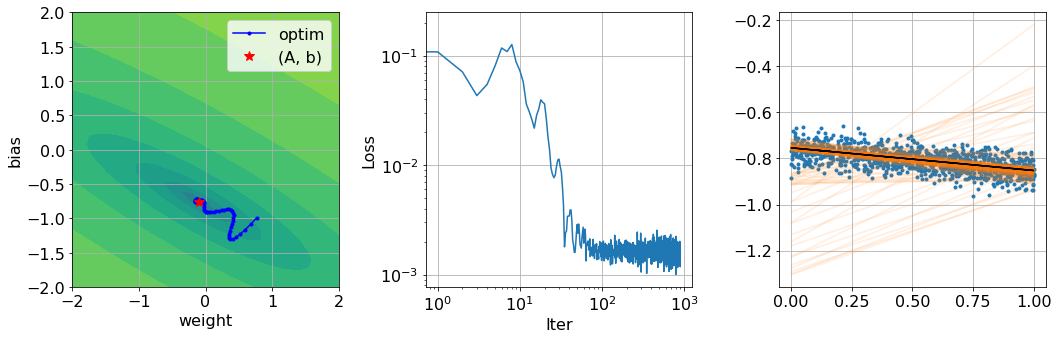

In [29]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
ax.plot(A[0], b, 'r*', markersize=10)
ax.set_xlabel('weight')
ax.set_ylabel('bias')
ax.legend(['optim', '(A, b)'])
ax.grid(True)
ax.set_xlim(-2, 2) 
ax.set_ylim(-2, 2) 

ax = fig.add_subplot(1, 3, 2)
ax.loglog(np.abs(train_hist['loss']))
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')
ax.grid(True)

ax = fig.add_subplot(1, 3, 3)
ax.plot(X_train, y_train, '.')
a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
for y in y_pred[1:]:
    ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
ax.plot(X_test, y_pred[-1], 'k')
ax.grid(True)   

fig.tight_layout()
